## Load Meetup data in Spark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Meetup data processing").getOrCreate()

In [395]:
import json
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
import numpy as np
from wordcloud import WordCloud
from sklearn import datasets, linear_model

In [423]:
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [396]:
categories = spark.read.format("csv").option("header", "true").load('./data/categories.csv')
cities = spark.read.format("csv").option("header", "true").load('./data/cities.csv')
events = spark.read.format("csv").option("header", "true").load('./data/events.csv')
groups = spark.read.format("csv").option("header", "true").load('./data/groups.csv')
groupTopics = spark.read.format("csv").option("header", "true").load('./data/groups_topics.csv')
members = spark.read.format("csv").option("header", "true").load('./data/members.csv')
memberTopics = spark.read.format("csv").option("header", "true").load('./data/members_topics.csv')
topics = spark.read.format("csv").option("header", "true").load('./data/topics.csv')
venues = spark.read.format("csv").option("header", "true").load('./data/venues.csv')

### Analyzing the most frequent Topics from Active Meetup Members - Word Cloud

In [397]:
tmpMemTopic = memberTopics.groupby('topic_key').count()

In [398]:
tmpMemTopic = tmpMemTopic.orderBy('count', ascending=False).limit(30)

In [399]:
tmpMemTopic.show(n=30, truncate=False)

+----------------------------------------+------+
|topic_key                               |count |
+----------------------------------------+------+
|Outdoors                                |160829|
|New Technology                          |142536|
|Art                                     |132901|
|Watching Movies                         |103915|
|Wine                                    |97698 |
|Music                                   |94133 |
|Performing Arts                         |87294 |
|Sports and Recreation                   |81124 |
|Social                                  |74925 |
|Wellness                                |74856 |
|Photography                             |72355 |
|Language & Culture                      |70488 |
|Eating, Drinking, Talking, Laughing, Etc|69256 |
|Dancing                                 |57129 |
|20's & 30's Social                      |55729 |
|Mobile Technology                       |54202 |
|Crafts                                  |53405 |


In [400]:
tmpMemTopicDf = tmpMemTopic.toPandas()

In [401]:
a = {}
for index, row in tmpMemTopicDf.iterrows():
     a[row['topic_key']] = row['count']

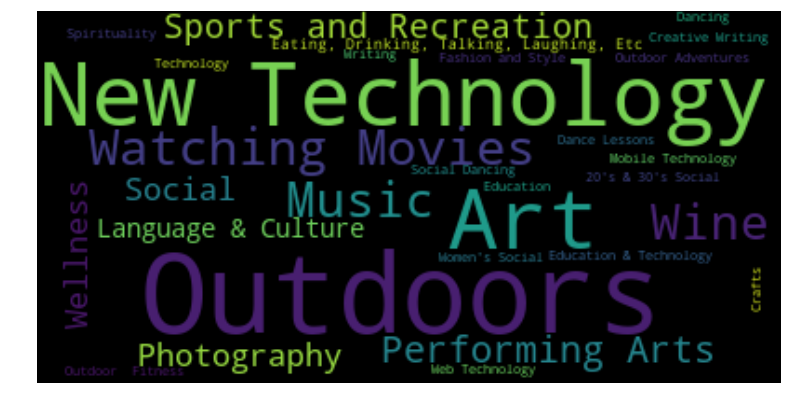

In [406]:
wordcloud = WordCloud().generate_from_frequencies(a)
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Trend of top topics over years - Stack Plot

In [407]:
uniqueGrps = groups.select("`group_id`", year(groups.created).alias('dt_year')).distinct()

In [408]:
groupTopics.show()

+--------+----------+----------+--------+
|topic_id| topic_key|topic_name|group_id|
+--------+----------+----------+--------+
|      83|sportsfans|Sports Fan|  241031|
|      83|sportsfans|Sports Fan|  289172|
|      83|sportsfans|Sports Fan|  295444|
|      83|sportsfans|Sports Fan| 1040320|
|      83|sportsfans|Sports Fan| 1403055|
|      83|sportsfans|Sports Fan| 1426482|
|      83|sportsfans|Sports Fan| 1491757|
|      83|sportsfans|Sports Fan| 1492775|
|      83|sportsfans|Sports Fan| 1621920|
|      83|sportsfans|Sports Fan| 1683009|
|      83|sportsfans|Sports Fan| 1714061|
|      83|sportsfans|Sports Fan| 1733916|
|      83|sportsfans|Sports Fan| 3546292|
|      83|sportsfans|Sports Fan| 3680352|
|      83|sportsfans|Sports Fan| 3785922|
|      83|sportsfans|Sports Fan| 3884992|
|      83|sportsfans|Sports Fan| 4021122|
|      83|sportsfans|Sports Fan| 4274282|
|      83|sportsfans|Sports Fan| 4286742|
|      83|sportsfans|Sports Fan| 4316032|
+--------+----------+----------+--

In [409]:
unique_grptopics = groupTopics.select("group_id","topic_name").where(col("topic_name").isin({"Outdoors", "New Technology", "Art", "Watching Movies", "Wine", "Music"})).distinct()

In [410]:
df1 = unique_grptopics.alias('df1')
df2 = uniqueGrps.alias('df2')
topics_year = df1.join(df2, df1.group_id == df2.group_id).select('df1.topic_name','df2.dt_year')

In [411]:
topics_year = topics_year.groupby("topic_name","dt_year").count()

In [412]:
topics_year = topics_year.where(col("dt_year") >= 2006).orderBy("topic_name","dt_year")

In [413]:
data = {}
data["Outdoors"] = []
data["New Technology"] = []
data["Art"] = []
data["Watching Movies"] = []
data["Wine"] = []
data["Music"] = []
tmp_topics_year = topics_year.toPandas()
for index, row in tmp_topics_year.iterrows():
     data[row['topic_name']].append(row["count"])

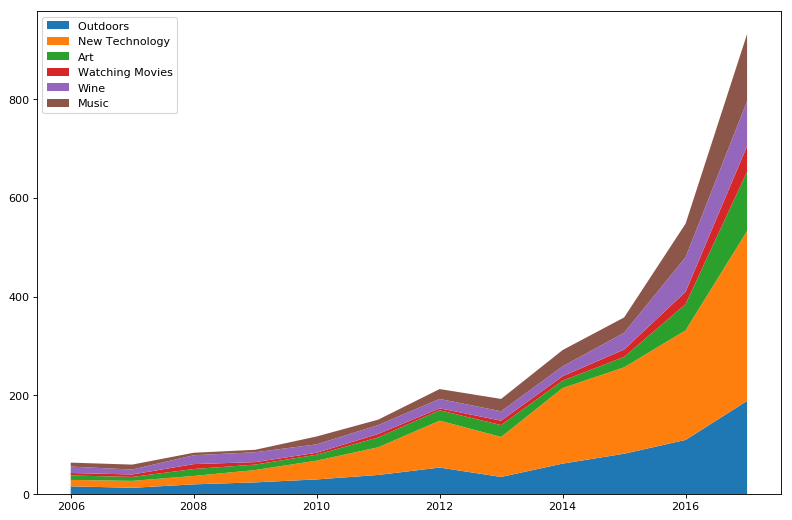

In [415]:
x = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
y = np.vstack([data["Outdoors"], data["New Technology"], data["Art"], data["Watching Movies"],data["Wine"], data["Music"] ])
labels = ["Outdoors ", "New Technology", "Art", "Watching Movies", "Wine", "Music"] 
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.stackplot(x, y, labels=labels)
plt.legend(loc=2)
plt.show()

### Most popular group - Horizontal Barchart

In [416]:
uniqMemberGrp = members.select("member_id","group_id").distinct()

In [417]:
uniqGrp = groups.select("group_id","group_name").distinct()

In [418]:
df1 = uniqMemberGrp.alias('df1')
df2 = uniqGrp.alias('df2')
grp_subscriptions = df1.join(df2, df1.group_id == df2.group_id).select("df2.group_name", "df1.member_id")

In [419]:
grp_subscriptions = grp_subscriptions.groupBy("group_name").count()

In [420]:
grp_subscriptions = grp_subscriptions.orderBy("count", ascending=False).limit(30)

In [421]:
grp_subscriptions.show(n=30, truncate=False)
grp_subscriptions.count()

+------------------------------------------------------------+-----+
|group_name                                                  |count|
+------------------------------------------------------------+-----+
|20 and 30 Somethings Chicago                                |18134|
|CoInvent NY (a.k.a NYEBN)                                   |14165|
|Chicago Meetup                                              |13869|
|Hudson Valley Hikers                                        |13549|
|I wanted to do that...just not   alone!                     |13089|
|New York Entrepreneurs & Startup Network (NYESN)            |12699|
|20 and 30 somethings in San Francisco - AWESOME Stuff       |12506|
|The NYC Business Networking Group (NYCBNG): Award Winner!   |12238|
|SQL NYC, The NoSQL & NewSQL Database Meetup                 |11967|
|20s and 30s On The Town                                     |11726|
|Free NYC! Free Things To Do In NYC + beyond! (or very cheap)|11701|
|Alternative to the Bar Fun Things

30

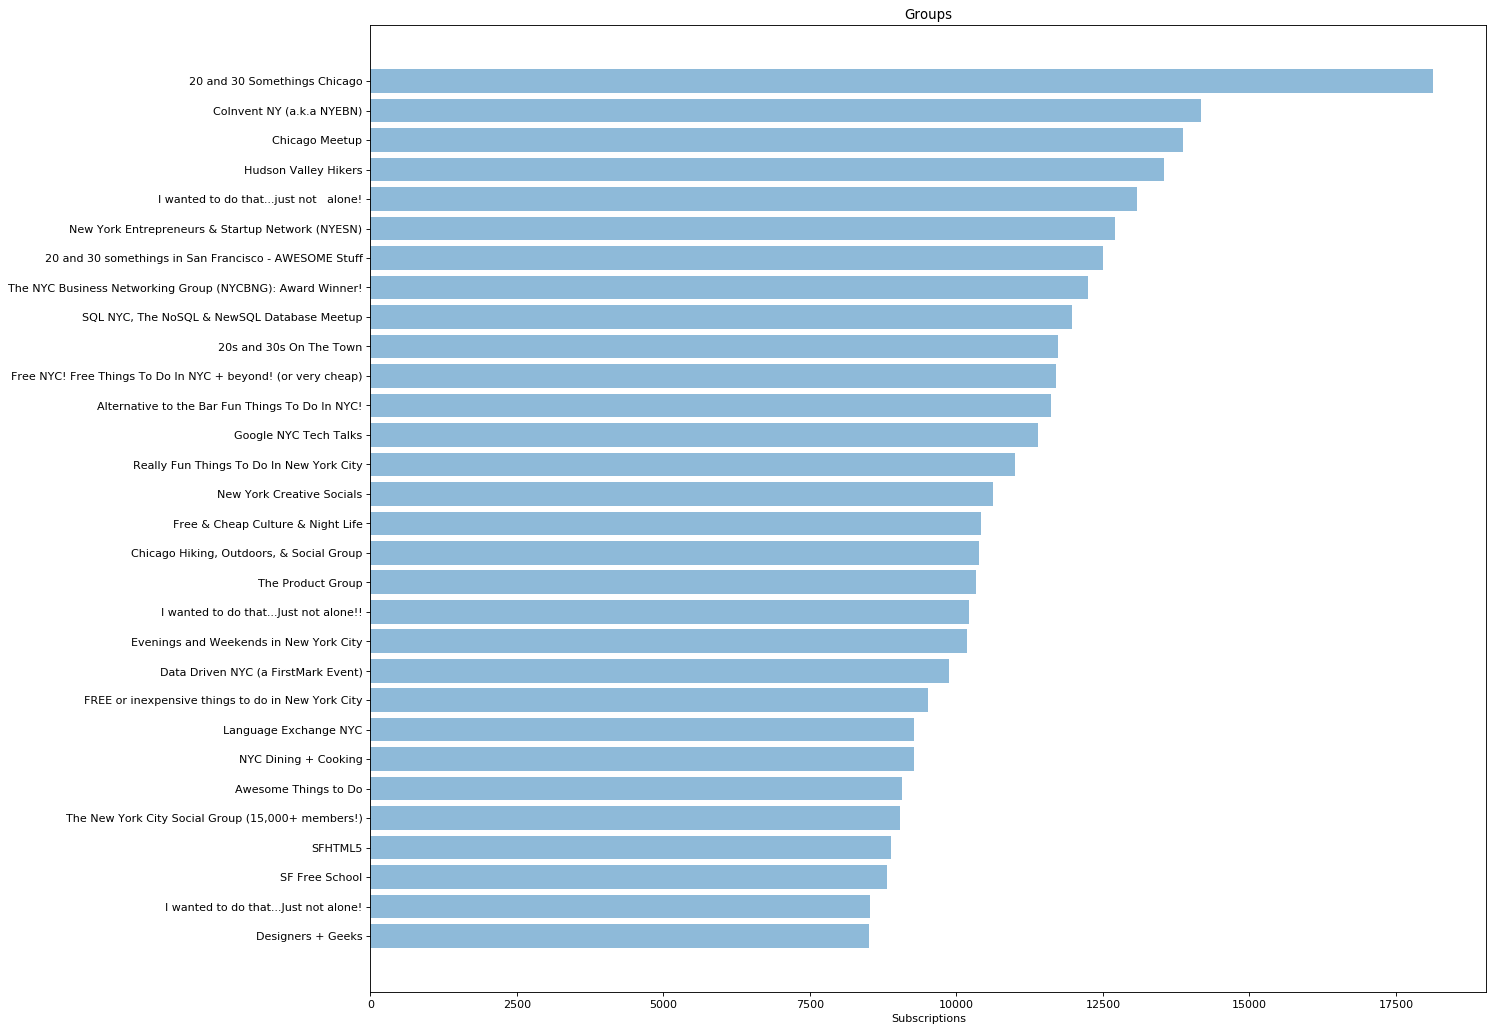

In [422]:
grp_subscriptions_tmp = grp_subscriptions.toPandas()
gName = []
gSize = []
for index, row in grp_subscriptions_tmp.iterrows():
     gName.append(row["group_name"])
     gSize.append(row["count"])
gName.reverse()
gSize.reverse()
y_pos = np.arange(len(gName))
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')     
plt.barh(y_pos, gSize, align='center', alpha=0.5)
plt.yticks(y_pos, gName)
plt.xlabel('Subscriptions')
plt.title('Groups')
plt.show()

### State with maximum groups and members

In [293]:
member_city = members.select("member_id", "city").distinct()
grp_city = groups.select("group_id","city").distinct()

In [294]:
member_city = member_city.groupby("city").count()
grp_city = grp_city.groupBy("city").count()

In [297]:
member_city = member_city.select("city", col("count").alias("member_count"))
grp_city = grp_city.select("city", col("count").alias("grp_count"))

In [300]:
df1 = member_city.alias('df1')
df2 = grp_city.alias('df2')
grp_member_city_cnt = df1.join(df2, df1.city == df2.city).select("df1.city", "df1.member_count", "df2.grp_count")

In [308]:
grp_member_city_cnt = grp_member_city_cnt.orderBy("grp_count","member_count", ascending=False)
grp_member_city_cnt.show()

+-------------------+------------+---------+
|               city|member_count|grp_count|
+-------------------+------------+---------+
|           New York|      579217|     8565|
|      San Francisco|      268955|     4555|
|            Chicago|      235211|     3168|
|South San Francisco|        2040|       19|
|      West New York|        1667|       11|
|      Chicago Ridge|         180|        5|
|       West Chicago|         189|        4|
|    Chicago Heights|         273|        2|
|      North Chicago|         119|        1|
+-------------------+------------+---------+



In [309]:
grp_member_city_cnt_tmp = grp_member_city_cnt.toPandas()

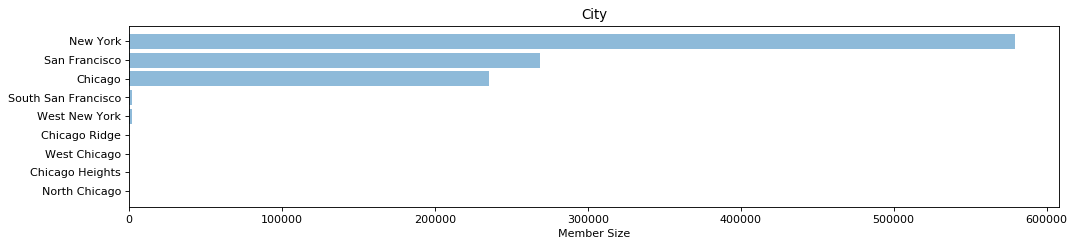

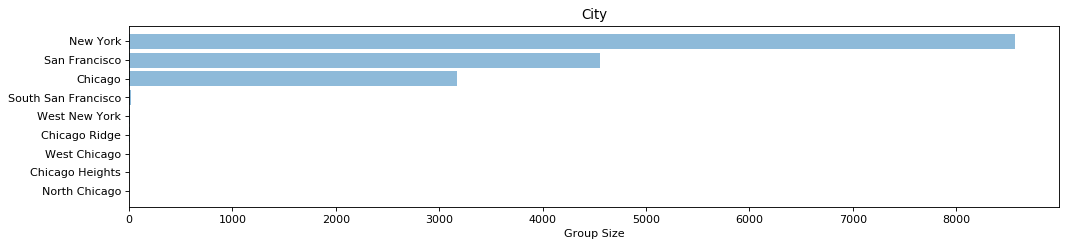

In [325]:
city_membr_cnt = []
city_grp_cnt = []
city = []
for index, row in grp_member_city_cnt_tmp.iterrows():
     city.append(row["city"])
     city_membr_cnt.append(row["member_count"])
     city_grp_cnt.append(row["grp_count"])
city_membr_cnt.reverse()
city_grp_cnt.reverse()
city.reverse()

# create plot
#fig, ax = plt.subplots()
y_pos = np.arange(len(city))
fig=plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')     
plt.barh(y_pos, city_membr_cnt, align='center', alpha=0.5)
plt.yticks(y_pos, city)
plt.xlabel('Member Size')
plt.title('City')
plt.show()

fig=plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k') 
plt.barh(y_pos, city_grp_cnt, align='center', alpha=0.5)
plt.yticks(y_pos, city)
plt.xlabel('Group Size')
plt.title('City')
plt.show()

### Linear regression model for Group size and Member size

In [378]:
cmc = np.asarray(city_membr_cnt)
cmc = cmc.reshape(len(city_membr_cnt), 1)
cgc = np.asarray(city_grp_cnt)
cgc = cgc.reshape(len(city_grp_cnt), 1)

('Coefficients: \n', array([[66.53028999]]))
Mean squared error: 205445421.95
Variance score: 0.99


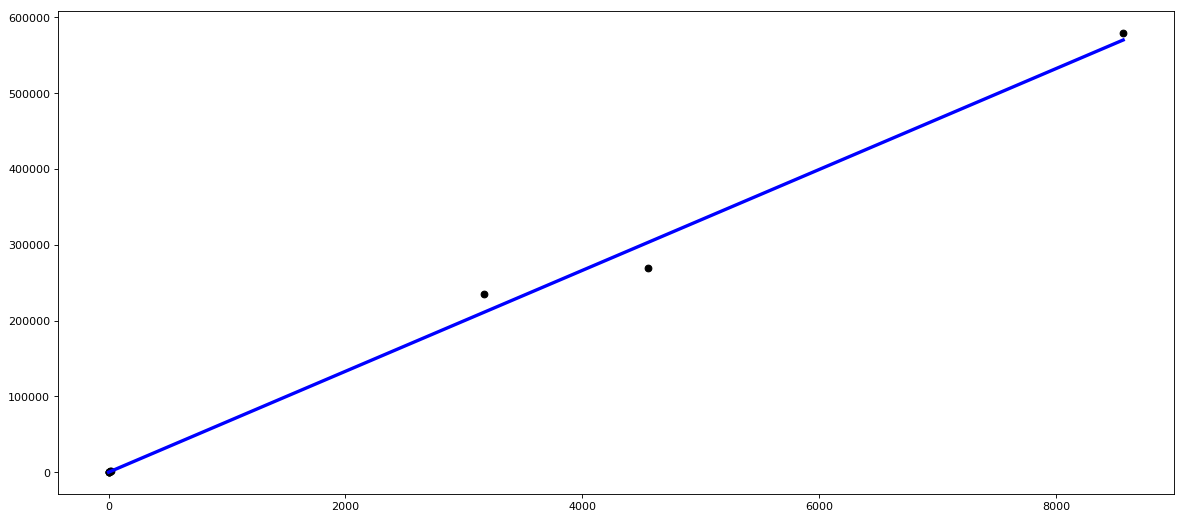

In [381]:
regr = linear_model.LinearRegression()
regr.fit(cgc, cmc)
yfit = regr.predict(cgc)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(cmc, yfit))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(cmc, yfit))
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k') 
plt.scatter(city_grp_cnt, city_membr_cnt, color='black')
plt.plot(cgc, yfit, color='blue', linewidth=3)

#### Predicting the number of Members Meetup can get if there are x number of groups

In [382]:
grpSize = [200, 500, 20]
gsize = np.asarray(grpSize)
gsize = gsize.reshape(3, 1)
yfit = regr.predict(gsize)

#### Expected Members Meetup.com can get for the above group size

In [383]:
yfit

array([[13462.87627579],
       [33421.96327203],
       [ 1487.42407804]])

In [424]:
t, p = ttest_ind(city_membr_cnt, city_grp_cnt, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = 1.75397  p = 0.117503


### Based on the T-Test outcome, since P value is very close to 0.1 we can reject null hypothesis at 90% confidence level

H0: There is no significant relation between #members and #groups

H1: Significant relation between #members and #groups